In [124]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Declare Variables 

In [125]:
n_states = 5 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_out = 2 # Number of motion variables [xi,x2]

n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#### Load Data 

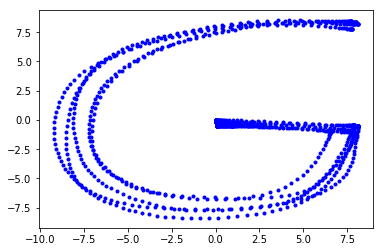

In [126]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[:n_samples]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

In [127]:
def subsample(X,N):
    '''Subsample in N iterations the trajectory X. The output is a 
    trajectory similar to X with N points. '''
    nx  = X.shape[0]
    idx = np.arange(float(N))/(N-1)*(nx-1)
    hx  = []
    for i in idx:
        i0 = int(np.floor(i))
        i1 = int(np.ceil(i))
        di = i%1
        x  = X[i0,:]*(1-di) + X[i1,:]*di
        hx.append(x)
    return np.vstack(hx)

In [128]:
data2 = []
for i in range(2):
    data2.append(data[i])
    
for i in range(2,4):
    data2.append(subsample(data[i][100:200,:],200))
    
for i in range(4,5):
    data2.append(subsample(data[i][:100,:],200))

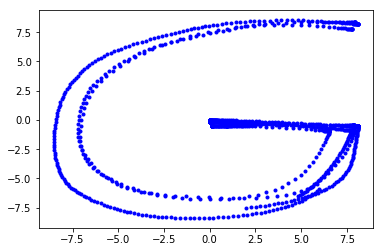

In [129]:
data2 = np.array(data2)
Y = np.concatenate(data2,axis=0)
plt.plot(Y[:,0], Y[:,1],'.b')

In [7]:
from scipy.stats import multivariate_normal as mvn

In [8]:
import numpy as np

In [176]:
realmin = np.finfo(np.double).tiny
realmax = np.finfo(np.double).max

class HMM(GMM):
    def __init__(self, D = 1, K = 2,  reg_factor = 1e-6):
        self.D = D #number of dimensions
        self.K = K #number of mixture components
        self.L = -np.inf #total log likelihood
        self.weights_ = np.ones(K)/K
        self.means_ = np.random.rand(K,D)
        self.covariances_ = np.array([np.eye(D) for i in range(K)])
        self.reg_factor =  reg_factor 

    def init_kmeans(self):
        x = self.xs.reshape(-1,self.xs.shape[-1])
        kMM = KMeans(n_clusters=self.K).fit(x)
        self.means_ = kMM.cluster_centers_
        for i in range(self.K):
            self.covariances_[i] = np.cov(x[kMM.labels_==i].T) + np.eye(self.D)*self.reg_factor
        
    def init_random(self):
        self.means_ = self.x[np.random.choice(len(self.x),size = self.K)]
        for i in range(self.K):
            self.covariances_[i] = np.cov(self.x.T)
            
    def init_kbins(self):
        x = self.xs.reshape(-1,self.xs.shape[-1])
        tsep = np.linspace(0,self.N, self.K+1).astype(int)
        idx = []
        for k in range(self.K):
            idx.append(np.concatenate([m*self.N + np.arange(tsep[k],tsep[k+1]) for m in range(self.M)]))
            self.means_[k] = np.mean(x[idx[k]],axis=0)
            self.covariances_[k] = np.cov(x[idx[k]].T) + np.eye(self.D)*self.reg_factor
        
    def init_HMM(self):
        self.weights_ = np.ones(self.K)/self.K
        self.Trans_ =  np.ones((self.K,self.K))/self.K
            
    def fit(self,xs, max_iter = 10, init_type = 'kmeans', threshold = 1e-6, n_init = 5):
        self.xs = xs
        self.M = len(self.xs) #number of samples
        self.N = len(self.xs[0]) #number of datapoints

        self.threshold = threshold
        
        best_params = ()
        Lmax = -np.inf
        for it in range(n_init):
            if init_type == 'kmeans':
                self.init_kmeans()
            elif init_type == 'random':
                self.init_random()
            elif init_type == 'kbins':
                self.init_kbins()
                

            self.init_HMM()
            
            for i in range(max_iter):
                print 'Iteration ' + str(i)
                self.expectation()
                self.maximization()
                print self.L
                if np.abs(self.prev_L-self.L) < self.threshold:
                    break
                    
            if self.L > Lmax:
                Lmax = self.L
                best_params = (self.L, self.weights_.copy(), self.means_.copy(), self.covariances_.copy())
            
        #return the best result
        self.L = Lmax
        self.weights_ = best_params[1]
        self.means_ = best_params[2]
        self.covariances_ = best_params[3]
        print 'Obtain best result with Log Likelihood: ' + str(self.L)
        

    def compute_messages(self,x,obs_slice=None):
        alpha = np.zeros((self.N,self.K)) 
        beta = np.zeros((self.N,self.K))
        gamma = np.zeros((self.N,self.K))
        zeta = np.zeros((self.N,self.K, self.K))
        B = np.zeros((self.N,self.K))
        c = np.zeros(self.N)
        
        #compute emission probabilities
        if obs_slice is not None:
            means_slice, covariances_slice = self.get_marginals(obs_slice)
            for k in range(self.K):
                B[:,k] = mvn(mean=means_slice[k], cov=covariances_slice[k]).pdf(x)            
        else:
            for k in range(self.K):
                B[:,k] = mvn(mean=self.means_[k], cov=self.covariances_[k]).pdf(x)

        #compute alpha
        alpha[0,:] = self.weights_ * B[0,:]
        c[0] = 1./(np.sum(alpha[0])+realmin)
        alpha[0] *= c[0]
        for n in range(1,self.N):
            alpha[n,:] = B[n,:]*np.dot(alpha[n-1,:], self.Trans_)
            c[n] = 1./(np.sum(alpha[n])+realmin)
            alpha[n] *= c[n]

        #compute beta
        beta[-1,:] = np.ones(self.K)*c[-1]
        for n in range(self.N-1,0,-1):
            beta[n-1,:] = np.dot(beta[n,:]*B[n,:], self.Trans_.T)
            beta[n-1,:] = (beta[n-1,:]*c[n-1])
                
                
        #compute likelihood
        L = -np.sum(np.log(c))

        #compute gamma
        for n in range(self.N):
            gamma[n,:] = alpha[n,:]*beta[n,:]/np.sum(alpha[n,:]*beta[n,:])

        #compute zeta
        for n in range(self.N-1):
            for k in range(self.K):
                zeta[n][k,:] = alpha[n,k]*B[n+1,:]*beta[n+1,:]*self.Trans_[k,:]

        return B,alpha,beta,gamma,zeta,L,c
            
    def expectation(self):
        self.prev_L = self.L

        self.alphas = np.zeros((self.M, self.N,self.K)) 
        self.betas = np.zeros((self.M, self.N,self.K))
        self.gammas = np.zeros((self.M, self.N,self.K))
        self.zetas = np.zeros((self.M, self.N,self.K, self.K))
        self.Bs = np.zeros((self.M,self.N,self.K))
        self.L = np.zeros(self.M)
        self.cs = np.zeros((self.M, self.N))
        
        for m in range(self.M):
            self.Bs[m], self.alphas[m], self.betas[m], self.gammas[m], self.zetas[m], self.L[m], self.cs[m] = \
                                                self.compute_messages(self.xs[m])
    
        self.L = np.mean(self.L)
             
    def maximization(self):
        x_mat = self.xs.reshape(-1,self.xs.shape[-1])
        gamma_mat = self.gammas.reshape(-1,self.gammas.shape[-1])
        zeta_mat = self.zetas.reshape(-1,self.zetas.shape[-2], self.zetas.shape[-1])
        self.x_mat = x_mat
        self.gamma_mat = gamma_mat
        self.zeta_mat = zeta_mat
        
        for k in range(self.K):
            #update weights
            self.weights_[k] =  np.mean(self.gammas[:,0,k]/np.sum(self.gammas[:,0,:],axis=1)) 

            means_k = np.zeros(self.D)
            sigma_k = np.zeros((self.D,self.D))
            
            #self.means_[k,:] 
            #self.covariances_[k,:]         
            
            for m in range(self.M):
                #update mean
                means_k += np.dot(self.gammas[m][:,k].T, self.xs[m])

                #update covariance
                x_reduce_mean = self.xs[m]-self.means_[k,:]
                sigma_k += dot(np.multiply(x_reduce_mean.T, self.gammas[m][:,k][None,:]), x_reduce_mean) 
            
            self.means_[k,:] = means_k / np.sum(self.gammas[:,:,k])
            self.covariances_[k,:] = sigma_k/np.sum(self.gammas[:,:,k])        + np.eye(self.D)*self.reg_factor
        
        self.Trans_ = np.sum(zeta_mat,axis=0)
        for k in range(self.K):
            self.Trans_[k,:] /= np.sum(self.Trans_[k,:])
        #/np.sum(zeta_mat,axis=(0,2))[:,None]
        
    def viterbi(self,x):
        self.delta = np.zeros((x.shape[0],self.K))
        self.psi = np.zeros((x.shape[0]-1,self.K))
        self.B = np.zeros((x.shape[0],self.K))
        
        self.opt_seq = np.zeros(x.shape[0]).astype(int)
        #compute emmision probabilities
        for k in range(self.K):
            self.B[:,k] = mvn(mean=self.means_[k], cov=self.covariances_[k]).logpdf(x)

        #initialise at n=0
        self.delta[0,:] = np.log(self.weights_) + self.B[0,:]
        for n in range(1,x.shape[0]):
            temp_vals = np.log(self.Trans_) + self.delta[n-1,:][:,None]
            self.delta[n,:] = self.B[n,:] + np.max(temp_vals, axis=0)
            self.psi[n-1,:] = np.argmax(temp_vals,axis=0)
        
        #find the optimal sequence
        self.opt_seq[-1] = np.argmax(self.delta[-1,:])
        for n in range(x.shape[0]-1, 0, -1):
            self.opt_seq[n-1] = self.psi[n-1,self.opt_seq[n]]
        return self.opt_seq
    
    def condition(self,x_in,dim_in,dim_out,h=None, return_gmm = False):
        _,alpha,_,_,_,_,_ =  self.compute_messages(x_in, dim_in)
        return super(HSMM,self).condition(x_in,dim_in,dim_out,h=alpha,return_gmm=return_gmm)
        
    def plot(self):
        fig,ax = plt.subplots()
        plot_GMM(self.means_, self.covariances_, ax)
        

In [177]:
hmm = HMM(D= 2, K=6)

In [178]:
hmm.fit(data,init_type='kbins',n_init = 1,max_iter=40)
clear_output()

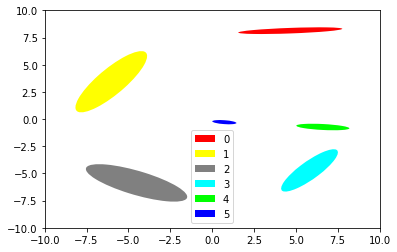

In [179]:
from utils import *

colors = [[1.,0.,0.],[1.,1.,0.],[0.5,0.5,0.5],[0.,1.,1.],[0.,1.,0.],[0.,0.,1.],]

fig,ax = plt.subplots()
plot_GMM(hmm.means_, hmm.covariances_,ax,labels=['0','1','2','3','4','5'],colors=colors)
plt.axis([-10,10,-10,10])
#plt.plot(Y[:,0], Y[:,1],'.b',alpha=0.2)
plt.legend()

In [118]:
hmm.compute_durations(hmm.xs)

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:175: RuntimeWarning: divide by zero encountered in log
/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:177: RuntimeWarning: divide by zero encountered in log


In [119]:
hmm.means_pd_

array([32.2, 29.4, 29.6, 24.2, 38.8, 45.8])

In [120]:
hmm.sigmas_pd_

array([  3.76,  25.44,   7.04,  22.96,   7.36, 115.76])

In [135]:
hmm.compute_forward_messages_HSMM(hmm.xs[2])

In [158]:
class Parent(object):
     def __init__(self):
         self.value = 4
     def get_value(self):
        print 'get'
        return self.value*2
 
class Child(Parent):
     def get_value(self):
         return Parent.get_value(self) + 1

In [159]:
a = Child()

In [160]:
a.get_value()

get


9

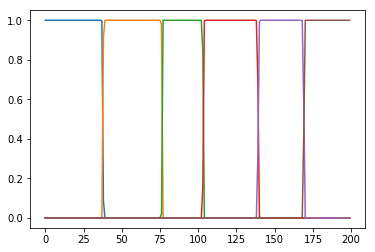

In [136]:
for i in range(hmm.K):
    plt.plot(hmm.h[:,i])

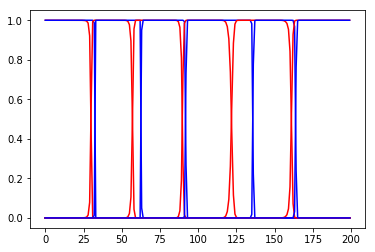

In [133]:
for i in range(hmm.K):
    plt.plot(hmm.alphas[4][:,i],'r')
    plt.plot(hmm.h[:,i],'b')
        

In [114]:
realmin = np.finfo(np.double).tiny
realmax = np.finfo(np.double).max

class HSMM(HMM):
    def compute_durations(self, xs):
        self.state_durs = dict()
        for k in range(self.K):
            self.state_durs[k] = []

        #compute the optimal state sequences for the data xs
        opt_seqs = []
        for x in xs:
            opt_seqs += [self.viterbi(x)]
        
        #compute the state duration for each sequence    
        for opt_seq in opt_seqs:
            cur_state = opt_seq[0]
            cur_count = 1
            for s in opt_seq[1:]:
                if cur_state == s:
                    cur_count += 1
                else:
                    self.state_durs[cur_state] += [cur_count]
                    cur_state = s
                    cur_count = 1
            #for the last state
            self.state_durs[cur_state] += [cur_count]
        
        #compute the duration probability as Gaussian Distribution for each state
        self.means_pd_ = np.zeros(self.K)
        self.sigmas_pd_ = np.zeros(self.K)
        for k in range(self.K):
            self.means_pd_[k] = np.mean(self.state_durs[k])
            self.sigmas_pd_[k] = np.var(self.state_durs[k])
            
    def compute_forward_messages_HSMM(self,x, obs_slice = None):
        if obs_slice is not None:
            means_, covariances_ = self.get_marginals(obs_slice)
        else:
            means_, covariances_ = (self.means_, self.covariances_)
        
        
        #precompute duration probabilities at each time step
        num_dur_max = int(2.*self.N/self.K) #the number of maximum duration that will be considered
        self.Pd = np.zeros((num_dur_max,self.K))
        for k in range(self.K):
            self.Pd[:,k] = mvn(mean=self.means_pd_[k], cov=self.sigmas_pd_[k]).pdf(np.arange(num_dur_max))
            self.Pd[:,k] /= np.sum(self.Pd[:,k])
            
        h = np.zeros((self.N,self.K))
        c = np.zeros(self.N)
        c[0] = 1
        
        for t in range(self.N):
            for k in range(self.K):
                if t < num_dur_max:
                    o_tmp = np.prod(c[:t+1]*mvn(mean = means_[k], cov=covariances_[k]).pdf(x[:t+1]))
                    h[t,k] = self.weights_[k]*self.Pd[t,k]*o_tmp
                
                for d in range(np.min([t-1,num_dur_max])):
                    o_tmp = np.prod(c[t-d+1:t+1]*mvn(mean = means_[k], cov=covariances_[k]).pdf(x[t-d+1:t+1]))
                    h[t,k] += np.dot(h[t-d,:],self.Trans_[:,k])*self.Pd[d,k]*o_tmp
                    
            if t < self.N-1:
                c[t+1] = 1/np.sum(h[t,:])
            
        h = h/np.sum(h,axis=1)[:,None]
        return h,c
    def condition(self,x_in,dim_in,dim_out,h=None, return_gmm = False):
        h,_ =  self.compute_forward_messages_HSMM(x_in, dim_in)
        return GMM.condition(self,x_in,dim_in,dim_out,h=h,return_gmm=return_gmm)